In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import MatrixSymbol, Matrix, Identity
import sympy as sym
import control


# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Uso de librería "statsmodels"

Esta librería se usa mucho en aplicaciones estadísticas, pero tiene un compendio de métodos y funciones muy útiles para estimar modelos usando polinomios autorregresivos.

## Experimento de identificación

**Paso 1:** En este ejemplo cargamos datos exercise_05.csv.

,t,yn,un,y_1,y_2,y_3,u_1,u_2,u_3
3,0.3,-0.016311,2.0,-0.001797,-0.001077,-0.008732,2.0,2.0,2.0
4,0.4,0.034411,2.0,-0.016311,-0.001797,-0.001077,2.0,2.0,2.0
5,0.5,0.081260,2.0,0.034411,-0.016311,-0.001797,2.0,2.0,2.0
6,0.6,0.093702,2.0,0.081260,0.034411,-0.016311,2.0,2.0,2.0
7,0.7,0.072110,2.0,0.093702,0.081260,0.034411,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...
66,6.6,0.556235,2.0,0.609182,0.581968,0.600430,2.0,2.0,2.0
67,6.7,0.613997,2.0,0.556235,0.609182,0.581968,2.0,2.0,2.0
68,6.8,0.623490,2.0,0.613997,0.556235,0.609182,2.0,2.0,2.0
69,6.9,0.640722,2.0,0.623490,0.613997,0.556235,2.0,2.0,2.0


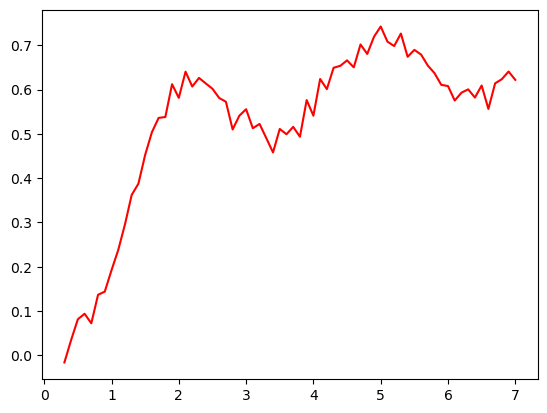

In [9]:
datos = pd.read_csv ('data\exercise_05.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = datos.un

datos['y_1'] = datos['yn'].shift(periods=1);
datos['y_2'] = datos['yn'].shift(periods=2);
datos['y_3'] = datos['yn'].shift(periods=3);
datos['u_1'] = datos['un'].shift(periods=1);
datos['u_2'] = datos['un'].shift(periods=2);
datos['u_3'] = datos['un'].shift(periods=3);

#datos = datos.fillna(0)
datos.dropna(inplace=True);


dt = (t[1] - t[0])

plt.plot(datos.t,datos.yn,color = 'red')
datos

**Paso 2:** A continuación, dividiremos los datos en conjuntos de entrenamiento y prueba:

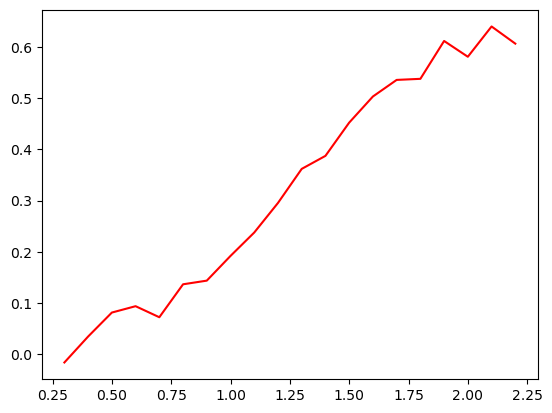

In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba
nobs_train = 20
train_data = datos[:nobs_train]
test_data = datos[nobs_train:]    
plt.plot(train_data['t'],train_data['yn'],color = 'red')

**Paso 3:** Ajustar un modelo a los datos de entrenamiento

In [11]:
# Crear matrices de diseño para los conjuntos de entrenamiento y prueba
exog_train = sm.add_constant(train_data[['y_1','y_2','y_3','u_2']])
exog_test = sm.add_constant(test_data[['y_1','y_2','y_3','u_2']])

# Ajustar el modelo 
model = sm.OLS(train_data['yn'], exog_train).fit()

# Imprimir un resumen del modelo
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     yn   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     270.7
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           6.42e-14
Time:                        09:08:02   Log-Likelihood:                 41.636
No. Observations:                  20   AIC:                            -75.27
Df Residuals:                      16   BIC:                            -71.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_1            0.7468      0.250      2.986      0.009       0.217       1.277
y_2            0.6072      0.307      1.976      0.066      -0.044       1.259
y_3           -0.3726      0.258     -1.445      0.168      -0.919       0.174
u_2            0.0162      0.008      2.115      0.050   -3.91e-05       0.032
==============================================================================
Omnibus:                        1.757   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.489
Skew:                          -0.560   Prob(JB):                        0.475
Kurtosis:                       2.271   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.0013117935695250637


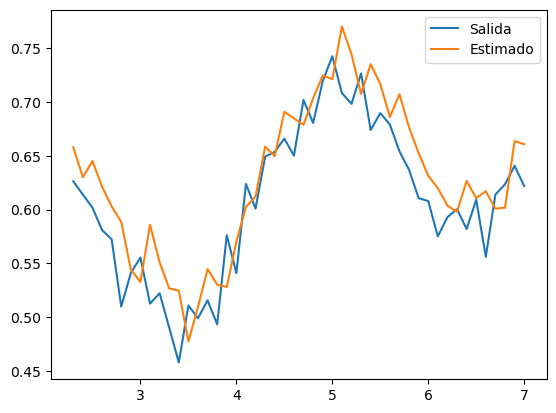

In [12]:
# Hacer predicciones en el conjunto de prueba
preds = model.predict(exog_test)

# Calcular el error cuadrático medio de las predicciones
mse = np.mean((preds - test_data['yn']) ** 2)

plt.plot(test_data['t'],test_data['yn'])
plt.plot(test_data['t'],preds)
plt.legend(['Salida','Estimado'])
print(mse)

In [13]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 - model.params.y_1*z**-1 - model.params.y_2*z**-2- model.params.y_3*z**-3
B =  model.params.u_2*z**-2
## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

0.0162120329474929*z/(z**3 - 0.746774626203412*z**2 - 0.6072453026854*z + 0.372563588540945)

array([[list([<matplotlib.lines.Line2D object at 0x00000116CCDDE6E0>]),
        list([<matplotlib.lines.Line2D object at 0x00000116CCDDE9E0>]),
        list([<matplotlib.lines.Line2D object at 0x00000116CCDDECE0>, <matplotlib.lines.Line2D object at 0x00000116CCDDEF80>, <matplotlib.lines.Line2D object at 0x00000116CCDDF220>])]],
      dtype=object)

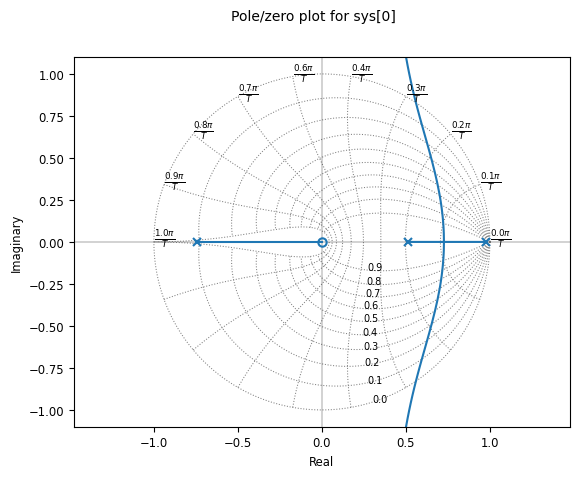

In [14]:
## Función de transferencia
G_e = control.tf([model.params.u_2,0],[1,-model.params.y_1,-model.params.y_2,-model.params.y_3],dt)
control.rlocus(G_e)

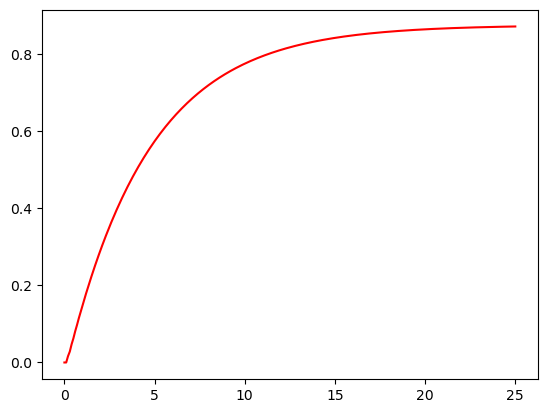

In [15]:
## Se determina la respuesta estimada al escalón
te,ye = control.step_response(G_e)
plt.plot(te,ye,color = 'red')
